<a href="https://colab.research.google.com/github/sh-biswas/demand-forecasting_Cogs109Final/blob/master/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)
%matplotlib inline

In [19]:
data = 'https://raw.githubusercontent.com/sh-biswas/demand-forecasting_Cogs109Final/master/train.csv'
data = pd.read_csv(data)

# create arrays to hold parsed year, month, and day
years = np.empty(data.shape[0]).astype('int32')
months = np.empty(data.shape[0]).astype('int32')
days = np.empty(data.shape[0]).astype('int32')
#print(f"len(years): {len(years)}")

# parse "year", "month", and "day" from 'date' string
def date_parser(row):
  #print(f"row: \n{row}")
  #print(f"row['date']: {row['date']}")
  year, month, day = row['date'].split("-")
  #print(f"year: {year} | month: {month} | day: {day}")
  #print(f"row.name: {row.name}")
  years[row.name] = int(year); months[row.name] = month; days[row.name] = day;
  #print(years[row.name])

# call parser on all rows
data.apply(date_parser, axis=1)

# add "year", "month", and "day" columns to data
data['year'] = years
data['month'] = months
data['day'] = days


# separate out train and test data
data = data.sort_values(by = ['date'])
print(f"first test date: {data['date'].unique()[-90]}")
test = data[-45000:][data[-45000:]['item'] == 15]
train = data[:-45000][data[:-45000]['item'] == 15]
#print(f"length of train: {len(train)}")
#print(f"num train dates: {len(train['date'].unique())}")


first test date: 2017-10-03


In [20]:
print(f"THESE SHOULD BE THE SAME: \n{len(years)}\n{len(data.index)}")

THESE SHOULD BE THE SAME: 
913000
913000


In [21]:
train.head(20)

,date,store,item,sales,year,month,day
255640,2013-01-01,1,15,42,2013,1,1
257466,2013-01-01,2,15,65,2013,1,1
259292,2013-01-01,3,15,61,2013,1,1
261118,2013-01-01,4,15,46,2013,1,1
262944,2013-01-01,5,15,31,2013,1,1
264770,2013-01-01,6,15,38,2013,1,1
266596,2013-01-01,7,15,27,2013,1,1
268422,2013-01-01,8,15,44,2013,1,1
270248,2013-01-01,9,15,48,2013,1,1
272074,2013-01-01,10,15,51,2013,1,1


Check if there are any null values

In [22]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
year     0
month    0
day      0
dtype: int64

In [23]:
test.isnull().sum()

date     0
store    0
item     0
sales    0
year     0
month    0
day      0
dtype: int64

There are no null values in both our test and train datasets.

How many different stores are there in the train dataset?

In [24]:
num_stores = len(data.store.unique())
print(num_stores)

10


How many different items in the train dataset?

In [25]:
num_items = len(train.item.unique())
print(num_items)

1


In [26]:
train[:100][ (train['store'] == 1) | (train['store'] == 2) ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,date,store,item,sales,year,month,day
255640,2013-01-01,1,15,42,2013,1,1
257466,2013-01-01,2,15,65,2013,1,1
257467,2013-01-02,2,15,71,2013,1,2
255641,2013-01-02,1,15,33,2013,1,2
255642,2013-01-03,1,15,45,2013,1,3
257468,2013-01-03,2,15,53,2013,1,3
257469,2013-01-04,2,15,68,2013,1,4
255643,2013-01-04,1,15,39,2013,1,4
255644,2013-01-05,1,15,47,2013,1,5
257470,2013-01-05,2,15,77,2013,1,5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame inde

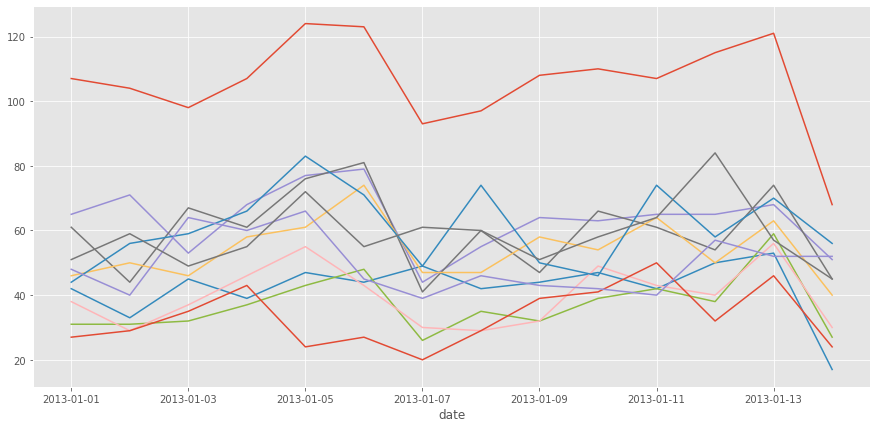

In [27]:
fig, ax = plt.subplots(figsize=(15,7))
train[:140][ (train['store'] == 1) | (train['store'] == 2) ].groupby('date').sum()['sales'].plot(x='date', y='sales', ax=ax)
for i in np.arange(1, 11):
  train[:140][ (train['store'] == i) ].groupby('date').sum()['sales'].plot(x='date', y='sales', ax=ax)

In [28]:
np.argmax(train.groupby(['item']).sum()['sales'])

0

In [29]:
len(train.groupby(['item']).sum()['sales'])

1

# Current Research Question: What are the predicted sales for the most popular item bought from the supplier by the stores for the next 3 months?

In [30]:
# just for store 1 to start
train_store1 = train[ train['store'] == 1]
test_store1 = test[ test['store'] == 1]


# let's do some linear regression!
A = np.vstack((np.ones(len(train_store1)), train_store1['year'], train_store1['month'], train_store1['day'])).T
w = np.linalg.lstsq(A, train_store1['sales'], rcond=None)[0]
print(f"1st order model: {w[0]:0.2f} + {w[1]:0.2f}*year + {w[2]:0.2f}*month + {w[3]:0.2f}*day")


1st order model: -13283.86 + 6.63*year + 1.32*month + -0.02*day


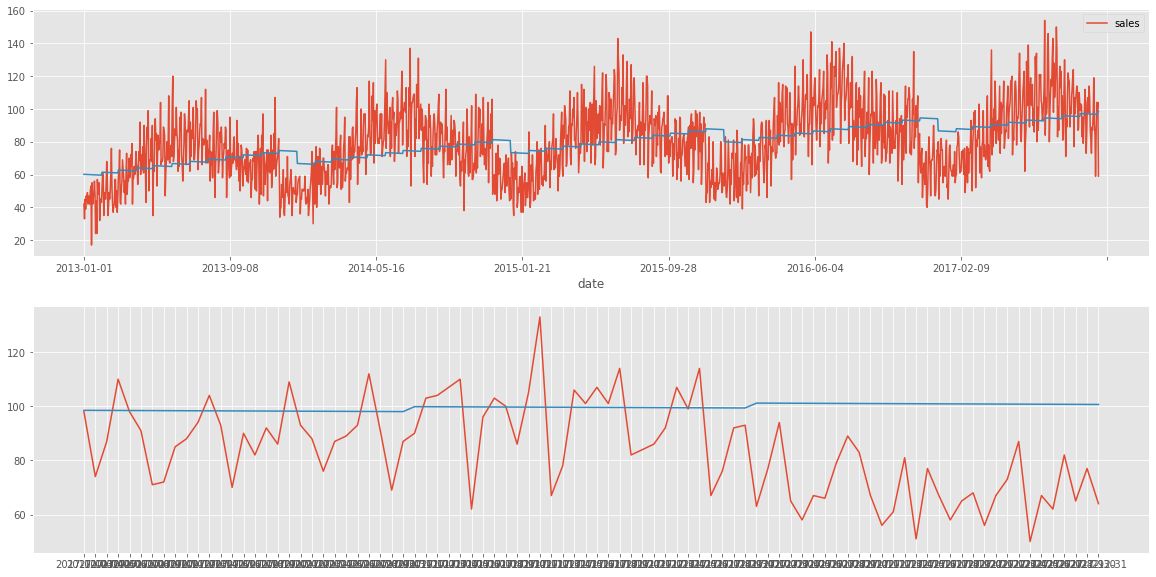

In [31]:
fig, axs = plt.subplots(2,1)
train_store1.plot(x='date', y='sales', figsize=(20,10), ax=axs[0])
axs[1].plot(test_store1['date'].values, test_store1['sales'].values)

## Create a smooth set of Y values for plotting the model
modelYtest = w[0] + w[1]*test_store1['year'].values + w[2]*test_store1['month'].values + w[3]*test_store1['day'].values
modelYtrain = w[0] + w[1]*train_store1['year'].values + w[2]*train_store1['month'].values + w[3]*train_store1['day'].values
axs[1].plot(test_store1['date'].values, modelYtest)
axs[0].plot(train_store1['date'].values, modelYtrain)


Model each item individually for all the stores -> supplier knows how many of each item to distribute over the time span of the test data(supplier perspective)

## First Order Model for All the Stores for Item 15

In [32]:
# let's do some linear regression!
A = np.vstack((np.ones(len(train)), train['year'], train['month'], train['day'])).T
w = np.linalg.lstsq(A, train['sales'], rcond=None)[0]
print(f"1st order model: {w[0]:0.2f} + {w[1]:0.2f}*year + {w[2]:0.2f}*month + {w[3]:0.2f}*day")

1st order model: -14287.85 + 7.13*year + 1.58*month + 0.01*day


MSE_train: 764.9046084586105 | MSE_test: 1076.3134147680912


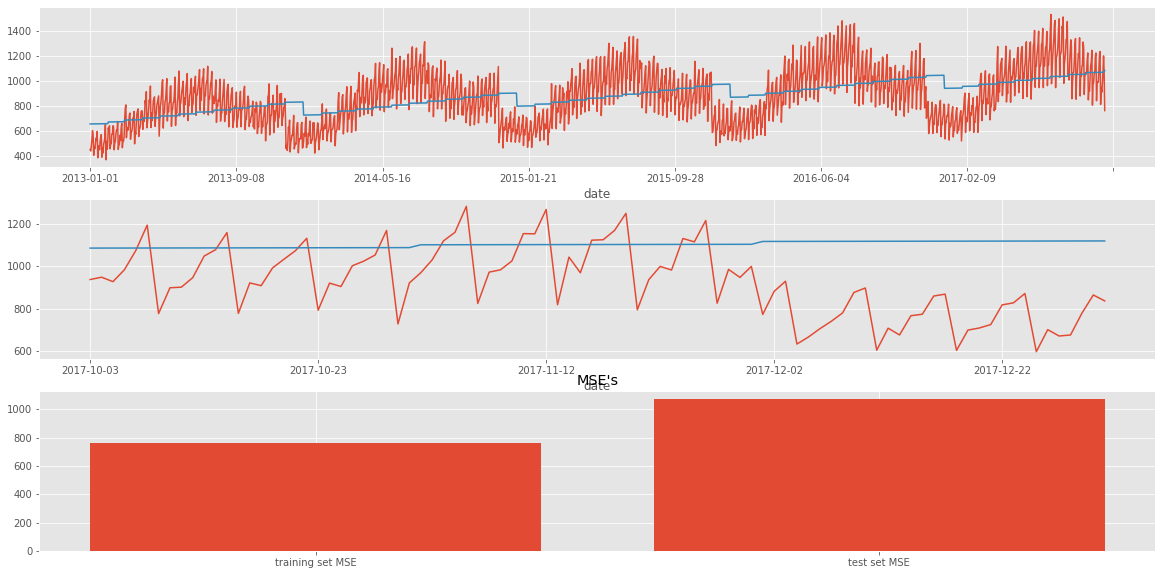

In [33]:
# plot the data
fig, axs = plt.subplots(3,1, figsize=(20,10))
train.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[0])
test.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[1])

## plot the model over data
#agg_train = train.groupby('date').sum(); agg_test = train.groupby('date').sum()
modelYtrain = w[0] + w[1]*train['year'].values + w[2]*train['month'].values + w[3]*train['day'].values
modelYtest = w[0] + w[1]*test['year'].values + w[2]*test['month'].values + w[3]*test['day'].values
train['1st-order model'] = modelYtrain; test['1st-order model'] = modelYtest;
train.groupby('date').sum()['1st-order model'].plot(x='date', y='1st-order model', ax=axs[0])
test.groupby('date').sum()['1st-order model'].plot(x='date', y='1st-order model', ax=axs[1])
#ax[0].plot(train['date'].unique().values, modelYtrain)
#ax[1].plot(test['date'].unique().values, modelYtest)

# plot MSE on train and test for model
MSE_train = np.mean((train['sales'].values - modelYtrain)**2)
MSE_test = np.mean((test['sales'].values - modelYtest)**2)
axs[2].bar(['training set MSE', 'test set MSE'], [MSE_train, MSE_test])
axs[2].set_title("MSE's")
fig.show()
print(f"MSE_train: {MSE_train} | MSE_test: {MSE_test}")

## Include the store as a term: sales and demands could possibly change model 

In [34]:
# let's do some linear regression!
A = np.vstack((np.ones(len(train)), train['year'], train['month'], train['day'], train['store'])).T
w = np.linalg.lstsq(A, train['sales'], rcond=None)[0]
print(f"1st order model: {w[0]:0.2f} + {w[1]:0.2f}*year + {w[2]:0.2f}*month + {w[3]:0.2f}*day + {w[4]:0.2f}*store")


1st order model: -14287.24 + 7.13*year + 1.58*month + 0.01*day + -0.11*store


MSE_train: 764.8013672790076 | MSE_test: 1076.0777008782366


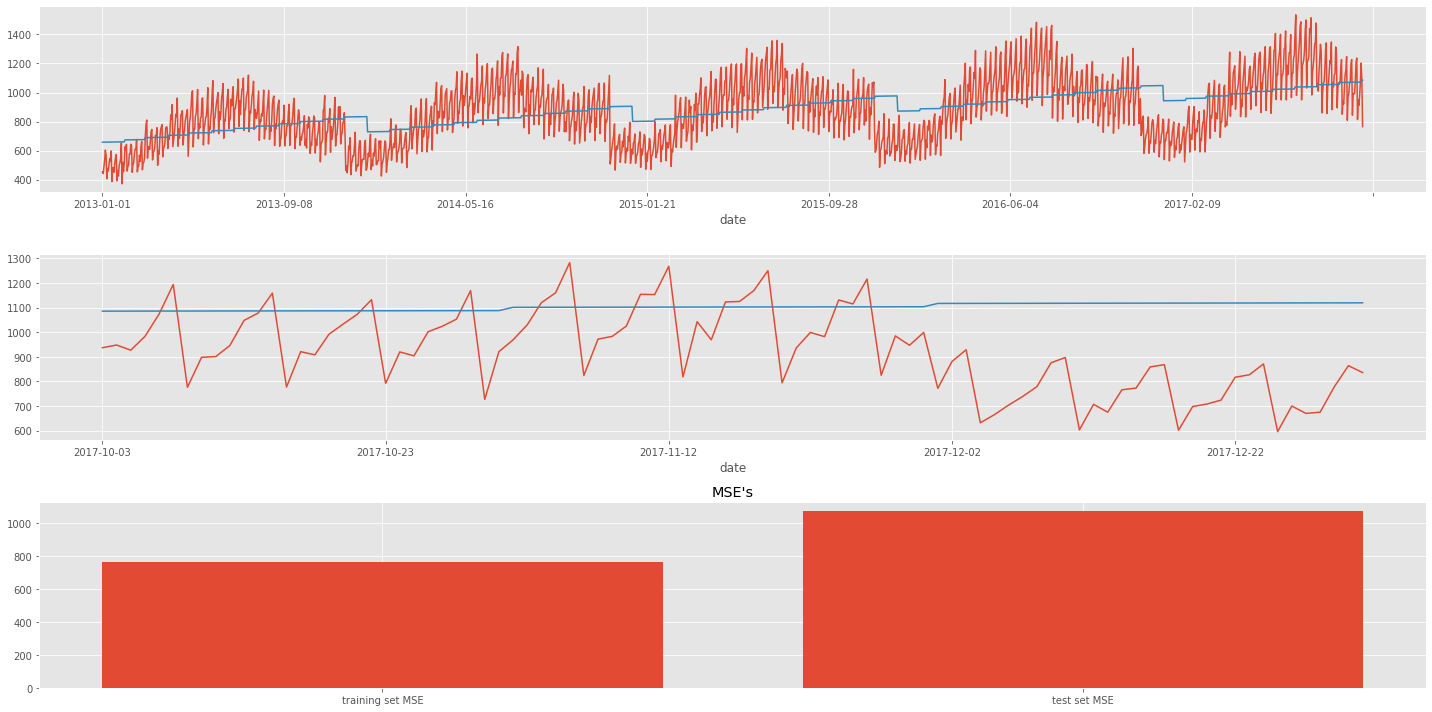

In [35]:
# plot the data
fig, axs = plt.subplots(3,1, figsize=(20,10))
train.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[0])
test.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[1])

## plot the model over the data
modelYtest = w[0] + w[1]*test['year'].values + w[2]*test['month'].values + w[3]*test['day'].values + w[4]*test['store'].values
modelYtrain = w[0] + w[1]*train['year'].values + w[2]*train['month'].values + w[3]*train['day'].values + w[4]*train['store'].values
train['1st-order model (w/ store)'] = modelYtrain; test['1st-order model (w/ store)'] = modelYtest;
train.groupby('date').sum()['1st-order model (w/ store)'].plot(x='date', y='1st-order model (w/ store)', ax=axs[0])
test.groupby('date').sum()['1st-order model (w/ store)'].plot(x='date', y='1st-order model (w/ store)', ax=axs[1])

# plot MSE on train and test for model
MSE_train = np.mean((train['sales'].values - modelYtrain)**2)
MSE_test = np.mean((test['sales'].values - modelYtest)**2)
axs[2].bar(['training set MSE', 'test set MSE'], [MSE_train, MSE_test])
axs[2].set_title("MSE's")
fig.tight_layout(); fig.show()
print(f"MSE_train: {MSE_train} | MSE_test: {MSE_test}")

In [36]:
len(train['date'].values)

17360

Although we know a 1st order model is not good at predicting the values, we used it to determine what kind of terms we would like. The general pattern of the data is matched by the regression model using regular terms and no cross-interaction terms. This makes sense because all the features we're using for our model(variables) do not depend on each other. 

The MSEs for our first-order models(with store and without store) are pretty much the same, but we decided to include the store as a variable because the patterns could depend on the store's demand, even though we're looking at this from the supplier's perspective, in which case only total demand matters and not individual store demand. 

## There are 10 bumps and dips in total in our plot of the training data -> we estimate that this would be a 10th-order model

In [37]:
# create matrix to perform linear regression on
order = 10
inputs = ['year', 'month', 'day', 'store']
mat = [np.ones(len(train))]
for input in inputs:
  for i in np.arange(1, order+1):
    print(f'appending train[{input}] ** {i}...')
    mat.append(train[input] ** i)

# perform linear regression
A = np.vstack(mat).T
w = np.linalg.lstsq(A, train['sales'], rcond=None)[0]
print(f"number of weights: {len(w)} = (0th order term) + order*num_inputs = 1 + {order}*{len(inputs)}")

# create string to print model
model_as_string = f'{order}-order model: {w[0]:0.2f}';
weight_idx = 1
for input in inputs:
  for i in np.arange(1, order+1):
    model_as_string += f" + {w[weight_idx]:0.2f}*{input}^{i}"
    weight_idx += 1

print(model_as_string)
#print(f"6th order model: {w[0]:0.2f} {w[4]:0.2f}*store + {w[1]:0.2f}*year + {w[5]:0.2f}*year^2 + {w[6]:0.2f}*year^3 + {w[7]:0.2f}*year^4 + {w[8]:0.2f}*year^5 + {w[9]:0.2f}*year^6 + {w[2]:0.2f}*month + {w[10]:0.2f}*month^2 + {w[11]:0.2f}*month^3 + {w[12]:0.2f}*month^4 + {w[13]:0.2f}*month^5 + {w[14]:0.2f}*month^6 + {w[3]:0.2f}*day + {w[15]:0.2f}*day^2 + {w[16]:0.2f}*day^3 + {w[17]:0.2f}*day^4 + {w[18]:0.2f}*day^5 + {w[19]:0.2f}*day^6 + {w[20]:0.2f}*store^2 + {w[21]:0.2f}*store^3 + {w[22]:0.2f}*store^4 + {w[23]:0.2f}*store^5 + {w[24]:0.2f}*store^6")

appending train[year] ** 1...
appending train[year] ** 2...
appending train[year] ** 3...
appending train[year] ** 4...
appending train[year] ** 5...
appending train[year] ** 6...
appending train[year] ** 7...
appending train[year] ** 8...
appending train[year] ** 9...
appending train[year] ** 10...
appending train[month] ** 1...
appending train[month] ** 2...
appending train[month] ** 3...
appending train[month] ** 4...
appending train[month] ** 5...
appending train[month] ** 6...
appending train[month] ** 7...
appending train[month] ** 8...
appending train[month] ** 9...
appending train[month] ** 10...
appending train[day] ** 1...
appending train[day] ** 2...
appending train[day] ** 3...
appending train[day] ** 4...
appending train[day] ** 5...
appending train[day] ** 6...
appending train[day] ** 7...
appending train[day] ** 8...
appending train[day] ** 9...
appending train[day] ** 10...
appending train[store] ** 1...
appending train[store] ** 2...
appending train[store] ** 3...
appe

MSE_train: 247.8032704657678 | MSE_test: 249.00537708404573


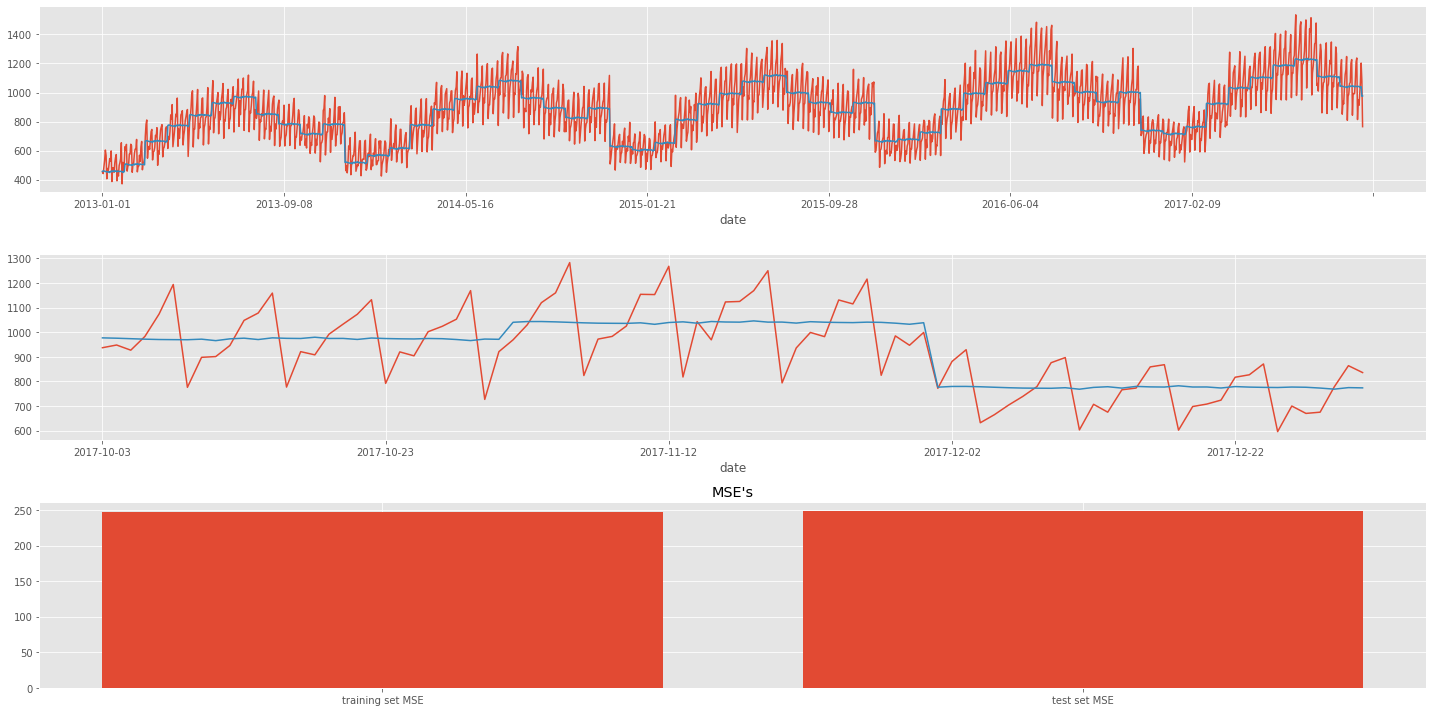

In [38]:
# plot the data
fig, axs = plt.subplots(3,1, figsize=(20,10))
train.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[0])
test.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[1])

## calculate predicted values for sales on train and test set
modelYtrain = w[0]
weight_idx = 1
for input in inputs:
  for i in np.arange(1, order+1):
    modelYtrain += w[weight_idx]*(train[input].values ** i)
    weight_idx += 1

modelYtest = w[0]
weight_idx = 1
for input in inputs:
  for i in np.arange(1, order+1):
    modelYtest += w[weight_idx]*(test[input].values ** i)
    weight_idx += 1

# plot model predictions over data
train[f'{order}-order model'] = modelYtrain; test[f'{order}-order model'] = modelYtest;
train.groupby('date').sum()[f'{order}-order model'].plot(x='date', y=f'{order}-order model', ax=axs[0])
test.groupby('date').sum()[f'{order}-order model'].plot(x='date', y=f'{order}-order model', ax=axs[1])

# plot MSE of model on train and test data
MSE_train = np.mean((train['sales'].values - modelYtrain)**2)
MSE_test = np.mean((test['sales'].values - modelYtest)**2)
axs[2].bar(['training set MSE', 'test set MSE'], [MSE_train, MSE_test])
axs[2].set_title("MSE's")
fig.tight_layout(); fig.show()
print(f"MSE_train: {MSE_train} | MSE_test: {MSE_test}")

In [39]:
test

,date,store,item,sales,year,month,day,1st-order model,1st-order model (w/ store),10-order model
259202,2017-10-03,2,15,119,2017,10,3,108.558354,108.949886,120.213993
268332,2017-10-03,7,15,57,2017,10,3,108.558354,108.390554,73.510839
257376,2017-10-03,1,15,98,2017,10,3,108.558354,109.061753,89.798464
264680,2017-10-03,5,15,73,2017,10,3,108.558354,108.614287,83.648915
271984,2017-10-03,9,15,93,2017,10,3,108.558354,108.166822,102.971922
...,...,...,...,...,...,...,...,...,...,...
266595,2017-12-31,6,15,69,2017,12,31,111.938362,111.882429,51.109533
268421,2017-12-31,7,15,51,2017,12,31,111.938362,111.770563,53.187424
270247,2017-12-31,8,15,105,2017,12,31,111.938362,111.658696,96.467398
272073,2017-12-31,9,15,77,2017,12,31,111.938362,111.546830,82.648508
